# Import

In [ ]:
import os
import pandas as pd
import cv2
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob
from tqdm import tqdm
from PIL import Image as im
import os.path
import tensorflow as tf
#vgg16
from keras.applications.vgg16 import preprocess_input as pi_vgg16
from keras.applications.vgg16 import VGG16
#vgg19
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as pi_vgg19
#resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as pi_res50
#xception
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as pi_x
#inceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as pi_v3

from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras import models
from tensorflow.keras import layers

import time


from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#Functions

In [ ]:
def agg_clustering(data, num_clusters, metric):
  cluster_model = AgglomerativeClustering(n_clusters=num_clusters, affinity=metric, linkage='average', compute_distances=True)

  clusters = cluster_model.fit_predict(data)

  score = silhouette_score(data, cluster_model.labels_, metric='euclidean')

  return clusters, score

In [ ]:
def transform(model):

  # get a list of the filenames
  labels = np.array(list(model.keys()))
  # get a list of just the features
  feat = np.array(list(model.values()))
  x=feat.shape[2]
  feat_re = feat.reshape(-1, x)

  scaler = preprocessing.StandardScaler()
  scaled = scaler.fit_transform(feat_re)

  return labels, scaled

In [ ]:
def dim_reduction_PCA (model,n_comp):

  # get a list of the filenames
  labels = np.array(list(model.keys()))
  # get a list of just the features
  feat = np.array(list(model.values()))
  x=feat.shape[2]
  feat_re = feat.reshape(-1, x)

  pca_model=PCA(n_components=n_comp, random_state=42)
  pca_model.fit(feat_re)
  vector_feat = pca_model.transform(feat_re)

  return labels, vector_feat

In [ ]:
def save_model(model, path_save):
  """
  permite guardar un modelo pkl

  model: el modelo que se quiere guardar

  path_model: es la ruta donde se guardará el archivo. Recuerde escribir el nombre del archivo y su extensión
  (e.g. /content/drive/MyDrive/Modelos_TesisMaster/PKL/denoise_audios.pkl )

  """
  s_file = open(path_save, "wb") #creo un archivo para escribir
  pickle.dump(model, s_file) # escribo sobre el archivo
  s_file.close() #lo cierro

In [ ]:
def load_model(path_model):
  """
  permite cargar un modelo pkl

  path_model: es la ruta de acceso del modelo

  esta funcion se debe asignar a una variable para que el modelo quede guardado ahi
  """

  l_file = open(path_model, "rb") #aqui lo leo
  model = pickle.load(l_file) #lo asigno a una variable
  l_file.close() #lo cierro

  return model

In [ ]:
def format_image_str_vgg16(m1,fx):
  """
  m1= un iterable con imagenes (numpy array)
  fx= factor de recorte
  wp= ancho actual de la imagen
  hf= altura deseada de la imagen
  wf= ancho deseado de la imagen

  """
  dim_matriz=len(m1)

  for i in range(dim_matriz):
    #reduce size array
    label=m1['label'][i]
    smaller_img = m1['image_as_array'][i][::fx, ::fx]
    hf=smaller_img.shape[0]
    wf=smaller_img.shape[1]
    #creo 2 canales ficticios para un total de 3 canales
    image = np.dstack([smaller_img] * 3)
    #seteo la forma de la imagen shape=(N, H, W, C)
    reshaped_img = image.reshape(1,hf,wf,3)
    #la preproceso segun keras
    imgx = pi_vgg16(reshaped_img)
    yield label, imgx


In [ ]:
def format_image_str_vgg19(m1,fx):
  """
  m1= un iterable con imagenes (numpy array)
  fx= factor de recorte
  wp= ancho actual de la imagen
  hf= altura deseada de la imagen
  wf= ancho deseado de la imagen

  """
  dim_matriz=len(m1)

  for i in range(dim_matriz):
    #reduce size array
    label=m1['label'][i]
    smaller_img = m1['image_as_array'][i][::fx, ::fx]
    hf=smaller_img.shape[0]
    wf=smaller_img.shape[1]
    #creo 2 canales ficticios para un total de 3 canales
    image = np.dstack([smaller_img] * 3)
    #seteo la forma de la imagen shape=(N, H, W, C)
    reshaped_img = image.reshape(1,hf,wf,3)
    #la preproceso segun keras
    imgx = pi_vgg19(reshaped_img)
    yield label, imgx


In [ ]:
def format_image_str_res50(m1,fx):
  """
  m1= un iterable con imagenes (numpy array)
  fx= factor de recorte
  wp= ancho actual de la imagen
  hf= altura deseada de la imagen
  wf= ancho deseado de la imagen

  """
  dim_matriz=len(m1)

  for i in range(dim_matriz):
    #reduce size array
    label=m1['label'][i]
    smaller_img = m1['image_as_array'][i][::fx, ::fx]
    hf=smaller_img.shape[0]
    wf=smaller_img.shape[1]
    #creo 2 canales ficticios para un total de 3 canales
    image = np.dstack([smaller_img] * 3)
    #seteo la forma de la imagen shape=(N, H, W, C)
    reshaped_img = image.reshape(1,hf,wf,3)
    #la preproceso segun keras
    imgx = pi_res50(reshaped_img)
    yield label, imgx


In [ ]:
def format_image_str_v3(m1,fx):
  """
  m1= un iterable con imagenes (numpy array)
  fx= factor de recorte
  wp= ancho actual de la imagen
  hf= altura deseada de la imagen
  wf= ancho deseado de la imagen

  """
  dim_matriz=len(m1)

  for i in range(dim_matriz):
    #reduce size array
    label=m1['label'][i]
    smaller_img = m1['image_as_array'][i][::fx, ::fx]
    hf=smaller_img.shape[0]
    wf=smaller_img.shape[1]
    #creo 2 canales ficticios para un total de 3 canales
    image = np.dstack([smaller_img] * 3)
    #seteo la forma de la imagen shape=(N, H, W, C)
    reshaped_img = image.reshape(1,hf,wf,3)
    #la preproceso segun keras
    imgx = pi_v3(reshaped_img)
    yield label, imgx


In [ ]:
def format_image_str_x(m1,fx):
  """
  m1= un iterable con imagenes (numpy array)
  fx= factor de recorte
  wp= ancho actual de la imagen
  hf= altura deseada de la imagen
  wf= ancho deseado de la imagen

  """
  dim_matriz=len(m1)

  for i in range(dim_matriz):
    #reduce size array
    label=m1['label'][i]
    smaller_img = m1['image_as_array'][i][::fx, ::fx]
    hf=smaller_img.shape[0]
    wf=smaller_img.shape[1]
    #creo 2 canales ficticios para un total de 3 canales
    image = np.dstack([smaller_img] * 3)
    #seteo la forma de la imagen shape=(N, H, W, C)
    reshaped_img = image.reshape(1,hf,wf,3)
    #la preproceso segun keras
    imgx = pi_x(reshaped_img)
    yield label, imgx


In [ ]:
def apply_model(modelo, generador):

  data = {}
  for i,j in generador:
    features = modelo.predict(j, use_multiprocessing=True)
    data[i] = features

  return data

# Datasets

In [ ]:
spec_full_df=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/spec_full_df.pkl")

In [ ]:
len(spec_full_df['lat_label'].value_counts())

21

In [ ]:
spec_full_df

,label,image_as_array,lat_label
0,XC195499_3,"[[255, 255, 255, 255, 255, 254, 253, 252, 251,...",5S
1,XC195499_4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5S
2,XC195499_5,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5S
3,XC195499_6,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5S
4,XC195499_7,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5S
...,...,...,...
4421,XC701136_5,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",35N
4422,XC701136_6,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",35N
4423,XC701136_7,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",35N
4424,XC701136_8,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",35N


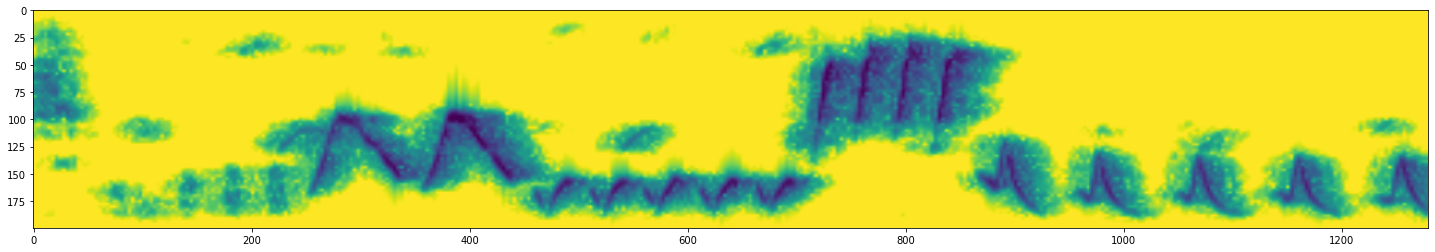

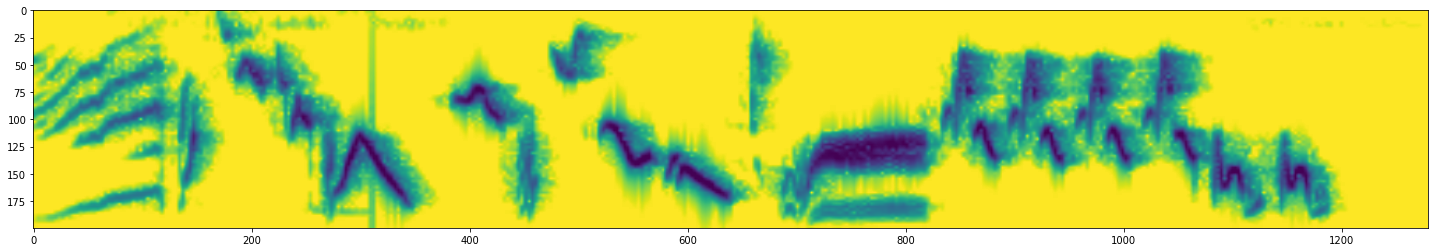

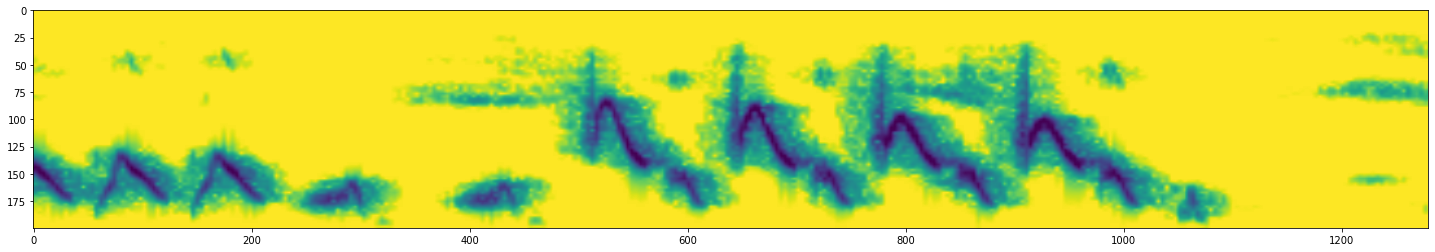

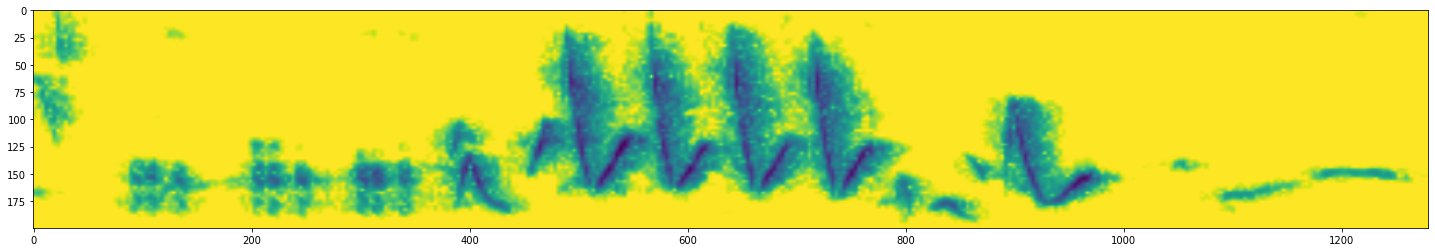

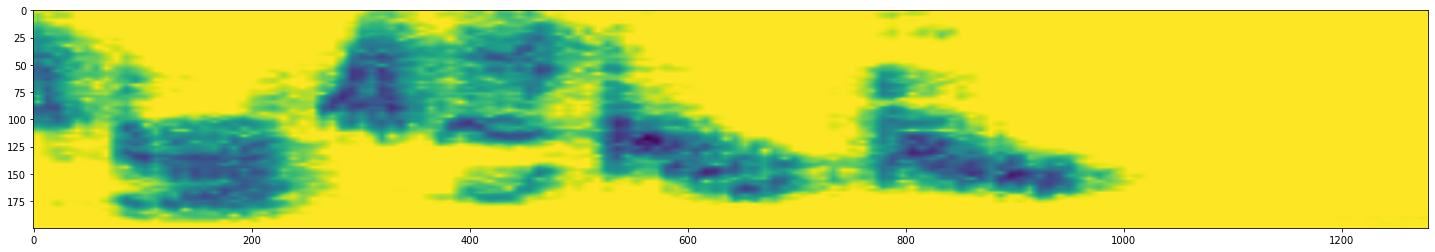

In [ ]:
import random
randomlist = []

for i in range(0,5):
  n = random.randint(0,4425)
  randomlist.append(n)


for i in randomlist:
  figure(figsize=(25,25))
  plt.imshow(spec_full_df.image_as_array[i])

In [ ]:
spec_full_df.image_as_array[0].shape

(200, 1280)

# Set CNN

## VGG16

![image](https://www.researchgate.net/publication/341208194/figure/fig3/AS:888538430193664@1588855478055/VGG16-architecture-26-ReLU-is-a-linear-rectifier-function-which-is-an-activation.jpg)

In [ ]:
base_model=tf.keras.applications.VGG16( include_top=False, input_shape=(100,640,3), weights='imagenet' )
x=base_model.output
x=layers.Flatten()(x)
x=layers.Dense(units=4096,activation="relu", name="fc1")(x)
output=layers.Dense(units=4096,activation="relu", name="fc2")(x)

model_VGG16=Model(inputs=base_model.input, outputs=output)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 320, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 320, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 320, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 160, 128)      0     

## VGG19

![image](https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

In [ ]:
base_model=tf.keras.applications.VGG19( include_top=False, input_shape=(100,640,3), weights='imagenet' )
x=base_model.output
x=layers.Flatten()(x)
x=layers.Dense(units=4096,activation="relu", name="fc1")(x)
output=layers.Dense(units=4096,activation="relu", name="fc2")(x)

model_VGG19=Model(inputs=base_model.input, outputs=output)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model_VGG19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 320, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 320, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 320, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 160, 128)      0     

## Resnet50

In [ ]:
base_model_Res50=ResNet50( include_top=False, weights='imagenet', pooling='avg', input_shape=(100,640,3))
model_Res50=Model(inputs=base_model_Res50.input, outputs=base_model_Res50.output)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model_Res50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 646, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 320, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 320, 64)  256         ['conv1_conv[0][0]']       

## InceptionV3

In [ ]:
base_model_v3=InceptionV3( include_top=False, weights='imagenet', pooling='avg', input_shape=(100,640,3))
model_v3=Model(inputs=base_model_v3.input, outputs=base_model_v3.output)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_v3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 319, 32)  864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 319, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

## Xception

In [ ]:
base_model_x=Xception( include_top=False, weights='imagenet', pooling='avg', input_shape=(100,640,3))
model_x=Model(inputs=base_model_x.input, outputs=base_model_x.output)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
model_x.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 319, 32)  864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 319, 32)  128        ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

#Apply CNN

## VGG16

In [ ]:
inicio = time.time()
ImageGenerator_VGG16=format_image_str_vgg16(spec_full_df,2)
features_1R_full_VGG16=apply_model(model_VGG16,ImageGenerator_VGG16)
save_model(features_1R_full_VGG16,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG16.pkl")
fin = time.time()
print(f"El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:{fin-inicio} segundos")

1/1 [==============================] - 0s 27ms/step
El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:374.1082761287689 segundos


## VGG19

In [ ]:
inicio = time.time()
ImageGenerator_VGG19=format_image_str_vgg19(spec_full_df,2)
features_1R_full_VGG19=apply_model(model_VGG19,ImageGenerator_VGG19)
save_model(features_1R_full_VGG19,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG19.pkl")
fin = time.time()
print(f"El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:{fin-inicio} segundos")

1/1 [==============================] - 0s 18ms/step
El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:404.2716107368469 segundos


## Resnet50

In [ ]:
inicio = time.time()
ImageGenerator_res50=format_image_str_res50(spec_full_df,2)
features_1R_full_res50=apply_model(model_Res50,ImageGenerator_res50)
save_model(features_1R_full_res50,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_res50.pkl")
fin = time.time()
print(f"El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:{fin-inicio} segundos")

1/1 [==============================] - 0s 36ms/step
El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:355.2224051952362 segundos


## InceptionV3

In [ ]:
inicio = time.time()
ImageGenerator_v3=format_image_str_v3(spec_full_df,2)
features_1R_full_v3=apply_model(model_v3,ImageGenerator_v3)
save_model(features_1R_full_v3,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_v3.pkl")
fin = time.time()
print(f"El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:{fin-inicio} segundos")

1/1 [==============================] - 0s 27ms/step
El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:438.6896598339081 segundos


## Xception

In [ ]:
inicio = time.time()
ImageGenerator_x=format_image_str_x(spec_full_df,2)
features_1R_full_x=apply_model(model_x,ImageGenerator_x)
save_model(features_1R_full_x,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_x.pkl")
fin = time.time()
print(f"El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:{fin-inicio} segundos")

1/1 [==============================] - 0s 31ms/step
El vector esta listo y asalvo en su carpeta PKL. El proceso demoró:332.89204573631287 segundos
